In [4]:
# Connecting to TPU via Google Colab (needed only when running Bert model)

import tensorflow as tf

try:
  # TPU detection
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))


Running on TPU  ['10.79.117.194:8470']


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [5]:
# For running in google colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Step 1: Running the library file(library_classifier.ipynb)

%run '/content/drive/MyDrive/Research project 1/library_classifier.ipynb'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.3 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Step 2: Creating train, dev and test datasets

df=create_df()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

train_df size 3946
dev_df size 2959
test_df size 2960
verb count in train, dev & test 64 64 64


In [ ]:
"""
Please note that, Step 3 to Step 10 has to be run for each dataset(train, dev and test) 
"""

In [18]:
# Step 3: Getting the inputs for Bert i.e., tokens(input_ids) & verb positions

bert_input=get_bert_input(df[2]["Sentence"],df[2]["Token_ID"])

Maximum no. of tokens 398
Max no.of splits for verbs 5


In [19]:
# Step 4: Getting the Bert embeddings

with tpu_strategy.scope():
    bert_embed=get_bert(bert_input[0])

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [20]:
# Step 5: Selcting only sentence & verb embeddings from the bert embeddings

sent_and_verb_embed = get_sent_and_verb_embed(bert_embed,df[2]["Sentence"],bert_input[1])

bert embedding shape (2960, 6, 768)
sample embedding tf.Tensor(
[[ 1.3655096   1.0511383   1.0979121  ...  0.08296822 -0.8825487
  -0.2308129 ]
 [ 0.57203984  0.27268237 -0.174551   ... -0.02538614  0.5935935
  -0.2730767 ]
 [-0.03913849  0.81382996  0.36051887 ...  0.29497954 -0.32289433
  -0.29149848]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(6, 768), dtype=float32)


In [21]:
# Step 6: Saving the sent & verb embeddings in pickle

import pickle

with open('/content/drive/MyDrive/Research project 1/test_embed.pkl', 'wb') as f:
  pickle.dump(sent_and_verb_embed, f)



In [39]:
# Step 7: Loading embeddings from pickle

import pickle

with open('/content/drive/MyDrive/Research project 1/test_embed.pkl', 'rb') as f:
  test_embed = pickle.load(f)


In [ ]:
print("sample bert embeddings from pickle", test_embed[0])

sample bert embeddings from pickle tf.Tensor(
[[ 1.3655096   1.0511383   1.0979121  ...  0.08296822 -0.8825487
  -0.2308129 ]
 [ 0.57203984  0.27268237 -0.174551   ... -0.02538614  0.5935935
  -0.2730767 ]
 [-0.03913849  0.81382996  0.36051887 ...  0.29497954 -0.32289433
  -0.29149848]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(6, 768), dtype=float32)


In [26]:
# Step 8: Getting the ouput labels i.e., 1 for psych and 0 for non-psych

out_labels=get_out_labels(df[2]["non-psych"])

no. of output labels 2960
Sample output labels [0 1 1]


In [27]:
# Step 9: Saving output labels to pickle

import pickle

with open('/content/drive/MyDrive/Research project 1/test_label.pkl', 'wb') as f:
  pickle.dump(out_labels, f)


In [35]:
# Step 10: Loading output labels from pickle

import pickle

with open('/content/drive/MyDrive/Research project 1/dev_label.pkl', 'rb') as f:
  dev_label = pickle.load(f)


In [ ]:
print("Sample output labels from pickle",  dev_label[0:3])

Sample output labels from pickle [1 1 0]


In [30]:
# Step 11: Building the model1

model1=build_model1()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 768)]          0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1)                 4609      
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Step 12: Training model1 by passing the sentence, verb embeddings & output labels of train dataset

history=model1.fit(train_embed,train_label,batch_size=128, epochs=20)


Epoch 1/20
31/31 [==============================] - 1s 9ms/step - loss: 0.3013 - accuracy: 0.8708
Epoch 2/20
31/31 [==============================] - 0s 9ms/step - loss: 0.2000 - accuracy: 0.9232
Epoch 3/20
31/31 [==============================] - 0s 9ms/step - loss: 0.1664 - accuracy: 0.9402
Epoch 4/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1460 - accuracy: 0.9458
Epoch 5/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1336 - accuracy: 0.9486
Epoch 6/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1233 - accuracy: 0.9531
Epoch 7/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1167 - accuracy: 0.9562
Epoch 8/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1103 - accuracy: 0.9562
Epoch 9/20
31/31 [==============================] - 0s 9ms/step - loss: 0.1062 - accuracy: 0.9605
Epoch 10/20
31/31 [==============================] - 0s 9ms/step - loss: 0.1015 - accuracy: 0.9577
Epoch 11/20
31

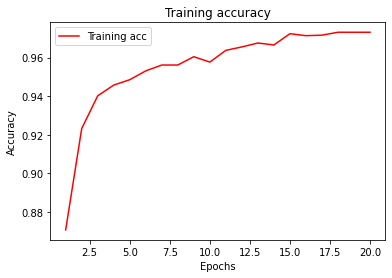

In [32]:
# Plotting the training accuracy of model1 in graph

import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict["accuracy"]
epochs = range(1, len(acc_values)+1)
plt.plot(epochs, acc_values, color="red", label="Training acc")
plt.title("Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [33]:
# Step 13: Saving the model1 which is trained

model1.save('/content/drive/MyDrive/Research project 1/model1.h5')

In [36]:
# Step 14: Loading the saved model 

model1 = tf.keras.models.load_model('/content/drive/MyDrive/Research project 1/model1.h5')

In [37]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 768)]          0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1)                 4609      
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Step 15: Evaluating model1 by passing dev data (validation)

model1_score = model1.evaluate(dev_embed, dev_label, batch_size=128)

24/24 [==============================] - 0s 9ms/step - loss: 0.1594 - accuracy: 0.9409


In [40]:
# Step 16: Testing model1 by passing test data

import pandas as pd

prediction = model1.predict(test_embed)
predict_binary_labels = list(map(lambda x: 0 if x<0.5 else 1, prediction))
print(predict_binary_labels[0:10])

predicted_labels = ["psych" if i==1 else "non-psych" for i in predict_binary_labels]
print(predicted_labels[0:10])

# Adding predicted_label column to the test dataset
test_df=pd.read_excel("/content/drive/MyDrive/Research project 1/test_df.xlsx")
test_df["predicted_label"] = predicted_labels
test_df["unmatched"] = ["matched" if i == j  else "unmatched" for i,j in zip(test_df["non-psych"],test_df["predicted_label"])]

# Calculating the test score of model1
final_score= len(test_df[test_df["unmatched"] == "matched"])/len(test_df["unmatched"])

# Printing the score & predicted labels result
print("Final accuracy score of model1: ", final_score)
print("Total no. of data in test dataset: ",len(test_df))
print("No. of data correctly predicted by model1: ", len(test_df[test_df["unmatched"] == "matched"]))
print("No. of data not correctly predicted by model1: ",len(test_df[test_df["unmatched"] == "unmatched"]))

# Saving the final output into exel file
test_df.to_excel('/content/drive/MyDrive/Research project 1/final_output_df.xlsx', index=False)

# Printing verbs which are not correctly predicted by the model during testing
temp_df=pd.DataFrame()
temp_df = test_df.loc[test_df["unmatched"] == "unmatched"]
temp_df = temp_df[["Verb"]]
    
vrb_unmtch_dct = temp_df["Verb"].value_counts().to_dict()
vrb_unmtch=str(vrb_unmtch_dct)
print("Below are the verbs & their counts for which model doesn't predict correct label during testing: ",vrb_unmtch)



93/93 [==============================] - 0s 3ms/step
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['non-psych', 'psych', 'psych', 'psych', 'psych', 'psych', 'psych', 'psych', 'psych', 'psych']
Final accuracy score of model1:  0.9378378378378378
Total no. of data in test dataset:  2960
No. of data correctly predicted by model1:  2776
No. of data not correctly predicted by model1:  184
Below are the verbs & their counts for which model doesn't predict correct label during testing:  {'guttun': 22, 'zusetzen': 21, 'provozieren': 19, 'schwerfallen': 18, 'stören': 15, 'aufwühlen': 10, 'genügen': 10, 'beruhigen': 9, 'quälen': 8, 'überfordern': 6, 'widerstreben': 6, 'verwirren': 6, 'ausreichen': 5, 'schmeicheln': 5, 'aufstoßen': 5, 'bewegen': 3, 'ekeln': 2, 'gefallen': 2, 'bekümmern': 2, 'zermürben': 2, 'plagen': 1, 'entmutigen': 1, 'nahegehen': 1, 'bedrücken': 1, 'einleuchten': 1, 'verstören': 1, 'irritieren': 1, 'auffallen': 1}
